In [ ]:
!pip install transformers

In [ ]:
import pandas as pd
import sklearn
from google.colab import drive
import nltk
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, AutoModel, AutoTokenizer


drive.mount('/content/gdrive')

# Dataset
# repository https://github.com/iresiragusa/NLP/tree/main
# https://www.kaggle.com/datasets/yufengdev/bbc-fulltext-and-category?select=bbc-text.csv
# scarichiamo il dataset e lo carichiamo su COLAB

root = "/content/gdrive/MyDrive/Colab Notebooks/torch/"
df = pd.read_csv(root+"data/BBC-text/bbc-text.csv")

Mounted at /content/gdrive


In [ ]:
# associo ad ogni categoria un indice, così ho delle label numeriche
labels_dict = {
    'business': 0,
    'politics': 1,
    'tech': 2,
    'sport': 3,
    'entertainment': 4
}

df['labels'] = df.apply(lambda row: labels_dict[row.category], axis = 1)

In [ ]:
# creo train, val e test

(x_train, x_test, y_train, y_test) = train_test_split(df['text'], df['labels'], test_size=0.2, random_state=17)

(x_train, x_val, y_train, y_val) = train_test_split( x_train, y_train, test_size=0.1, random_state=17)

In [ ]:
from transformers import AutoConfig, AutoModel, AutoTokenizer

model_name = "roberta-base"
config = AutoConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, config=config)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# come funziona il tokenizzatore di BERT

s = 'The quick brown fox, jumps over: the lazy dog.'
print(len(s))
print(s)
print(len(tokenizer.tokenize(s)))
print(tokenizer.tokenize(s)) # è la lista delle parole tokenizzate

tensors = True

# tk = tokenizer(s, add_special_tokens=True, return_tensors="pt")
# restituisce un dizionario con i seguenti campi
# input_ids -> tokens numerici
# token_type_ids -> se 0 è la prima frase, se è 1 è la  seconda [CLS] sentence 1 [SEP] sentence 2
# attention_mask -> 1 se c'è un token in posizione, si vede meglio sotto quando passo una lista di frasi da processare

if tensors:
    tk = tokenizer(s, add_special_tokens=True, return_tensors="pt")
    print(tk['input_ids'].shape)
    print(type(tk['input_ids']))
    print(tk['input_ids'])
    print('----')
    print(tk['attention_mask'].shape)
    print(type(tk['attention_mask']))
    print(tk['attention_mask'])
else:
    tk = tokenizer(s, add_special_tokens=False)
    print(len(tk['input_ids']))
    print(type(tk['input_ids']))
    print(tk['input_ids'])
    print('----')
    print(len(tk['attention_mask']))
    print(type(tk['attention_mask']))
    print(tk['attention_mask'])

46
The quick brown fox, jumps over: the lazy dog.
12
['the', 'quick', 'brown', 'fox', ',', 'jumps', 'over', ':', 'the', 'lazy', 'dog', '.']
torch.Size([1, 14])
<class 'torch.Tensor'>
tensor([[  101,  1996,  4248,  2829,  4419,  1010, 14523,  2058,  1024,  1996,
         13971,  3899,  1012,   102]])
----
torch.Size([1, 14])
<class 'torch.Tensor'>
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print(tokenizer.tokenize(s))
if tensors:
    tk = tokenizer(s, add_special_tokens=True, return_tensors="pt")
    print(tk['input_ids'].shape)
    print(type(tk['input_ids']))
    print(tk['input_ids'])
    print('----')
    print(tk['attention_mask'].shape)
    print(type(tk['attention_mask']))
    print(tk['attention_mask'])
else:
    tk = tokenizer(s, add_special_tokens=False)
    print(len(tk['input_ids']))
    print(type(tk['input_ids']))
    print(tk['input_ids'])
    print('----')
    print(len(tk['attention_mask']))
    print(type(tk['attention_mask']))
    print(tk['attention_mask'])

['the', 'quick', 'brown', 'fox', ',', 'jumps', 'over', ':', 'the', 'lazy', 'dog', '.']
torch.Size([1, 14])
<class 'torch.Tensor'>
tensor([[  101,  1996,  4248,  2829,  4419,  1010, 14523,  2058,  1024,  1996,
         13971,  3899,  1012,   102]])
----
torch.Size([1, 14])
<class 'torch.Tensor'>
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [ ]:
s = ['The quick brown fox',
     'jumps over: the lazy dog.',
     'The quick brown fox, jumps over: the lazy dog.']

tk = tokenizer(s, add_special_tokens=True, return_tensors="pt", padding=True)
print(tk['input_ids'].shape)
print(type(tk['input_ids']))
print(tk['input_ids'])
print('----')
print(tk['attention_mask'].shape)
print(type(tk['attention_mask']))
print(tk['attention_mask'])


torch.Size([3, 14])
<class 'torch.Tensor'>
tensor([[    0,   133,  2119,  6219, 23602,     2,     1,     1,     1,     1,
             1,     1,     1,     1],
        [    0,   267, 11768,    81,    35,     5, 22414,  2335,     4,     2,
             1,     1,     1,     1],
        [    0,   133,  2119,  6219, 23602,     6, 13855,    81,    35,     5,
         22414,  2335,     4,     2]])
----
torch.Size([3, 14])
<class 'torch.Tensor'>
tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])


In [ ]:
outputs = model(**tk)
last_hidden_states = outputs.last_hidden_state
print(last_hidden_states.shape)
# (n, l, d)
    # n batch size
    # l max len (padding value)
    # d emb size
print(last_hidden_states)
#print(outputs)

torch.Size([3, 14, 768])
tensor([[[-0.0633,  0.0878,  0.0058,  ..., -0.0603, -0.0532,  0.0037],
         [-0.1798, -0.0565,  0.2604,  ...,  0.0176,  0.0379,  0.1828],
         [-0.1793,  0.1984,  0.0795,  ..., -0.4205,  0.0426,  0.1241],
         ...,
         [-0.0439,  0.0719,  0.1323,  ...,  0.0635, -0.0428,  0.0897],
         [-0.0439,  0.0719,  0.1323,  ...,  0.0635, -0.0428,  0.0897],
         [-0.0439,  0.0719,  0.1323,  ...,  0.0635, -0.0428,  0.0897]],

        [[-0.1462,  0.0946, -0.0063,  ..., -0.1004, -0.0628, -0.0156],
         [ 0.0551, -0.0620, -0.0420,  ..., -0.2772, -0.0434,  0.0910],
         [-0.0131,  0.1782,  0.0057,  ..., -0.4606, -0.0345,  0.0100],
         ...,
         [-0.0063, -0.0916,  0.0834,  ..., -0.0252, -0.0698,  0.0268],
         [-0.0063, -0.0916,  0.0834,  ..., -0.0252, -0.0698,  0.0268],
         [-0.0063, -0.0916,  0.0834,  ..., -0.0252, -0.0698,  0.0268]],

        [[-0.1371,  0.0902, -0.0104,  ..., -0.0628, -0.0530,  0.0093],
         [-0.1730, -

In [ ]:
from transformers import pipeline


model = "bert-base-uncased"
task = "feature-extraction"
tokenizer = AutoTokenizer.from_pretrained(model)


text = 'The quick brown fox, jumps over: the lazy dog.'
tokenized_text = tokenizer.tokenize(text)


feature_extractor = pipeline(task = task, model=model, tokenizer=tokenizer)
result = feature_extractor(text, return_tensors=True)
# con pipeline di hugging face fa la stessa cosa, estrae i cls token

In [ ]:
s = 'The quick brown fox, jumps over: the lazy dog.'
tk = tokenizer(s, add_special_tokens=True, return_tensors="pt")
outputs = model(**tk)
last_hidden_states = outputs.last_hidden_state
print(last_hidden_states.shape)
# (n, l, d)
    # n batch size
    # l max len (padding value)
    # d emb size
print(last_hidden_states)
#print(outputs)

torch.Size([1, 14, 768])
tensor([[[-0.5449, -0.0099, -0.3117,  ..., -0.2595,  0.4935,  0.5315],
         [-0.4142, -0.4263, -0.3243,  ..., -0.0633,  1.3985, -0.1521],
         [-0.5988, -0.4446,  0.6228,  ..., -0.0395,  0.3968, -0.1668],
         ...,
         [ 0.2650,  0.2589,  0.1067,  ..., -0.2739,  0.3995,  0.4982],
         [-0.9317, -0.5384, -0.3776,  ...,  0.5825,  0.4579, -0.5600],
         [ 0.6834,  0.2844, -0.5239,  ...,  0.0819, -0.5736, -0.3002]]],
       grad_fn=<NativeLayerNormBackward0>)


In [ ]:
last_hidden_states == result

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

# rimozione stopword e creazione dataset

class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, y, stopwords):

        if stopwords:
            tokens_litt = [nltk.word_tokenize(text, language='english') for text
                           in list(x)]
            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w for w in sentence if not w.lower()
                in nltk.corpus.stopwords.words("english")]))
        else:
            tokens_litt = [nltk.word_tokenize(text, language='english') for text
                           in list(x)]
            text_clean = []
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                #sentence_clean = ' '.join([w.lower() for w in sentence])
                #text_clean.append(sentence_clean)
                text_clean.append(' '.join([w.lower() for w in sentence]))
            # ogni token è separato dall'altro con uno spazio
        self.texts = [text for text in text_clean]
        self.labels = [torch.tensor(label) for label in y]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_labels = self.get_batch_labels(idx)
        return batch_texts, batch_labels

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
hyperparameters = {
    "epochs": 5,
    "learning_rate": 1e-3,
    "batch_size": 64,
    "dropout": 0.1,
    #"stopwords": True,
    "stopwords": False,
    "h_dim": 768,
    "patience": 5,
    "min_delta": 0.01,
    #"language_model": "bert-base-uncased"
    "language_model": "roberta-base"
}

In [ ]:
#creo i dataset

train_dataset = Dataset(x_train, y_train, hyperparameters["stopwords"])
val_dataset = Dataset(x_val, y_val, hyperparameters["stopwords"])
test_dataset = Dataset(x_test, y_test, hyperparameters["stopwords"])

Tokenizing ... : 100%|██████████| 445/445 [00:00<00:00, 11895.66it/s]


In [ ]:
class ClassifierDeep(nn.Module):

    def __init__(self, labels, hdim, dropout):
        super(ClassifierDeep, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(hdim, hdim),
            nn.BatchNorm1d(hdim),
            nn.Dropout(dropout),
            nn.ReLU(),
            nn.Linear(hdim, labels),
            )

    def forward(self, input_texts):
        return self.classifier(input_texts)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramenti della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping
        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss                      # consideriamo la loss corrente
                                                                            # come nuova loss ottimale
            self.counter = 0                                                # e azzeriamo il contatore di pazienza

In [ ]:
def gen_embeddings(input_id_text, attention_mask, lm_model):
    with torch.no_grad():
        last_hidden_states = lm_model(input_id_text,
                            attention_mask=attention_mask).last_hidden_state
        last_hidden_states = last_hidden_states[:,0,:]
    return last_hidden_states

In [ ]:
def train_loop(model, dataloader, tokenizer, lm_model, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_labels in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()
        tokens = tokenizer(list(batch_texts), add_special_tokens=True,
                return_tensors='pt', padding='max_length',
                max_length = 512, truncation=True)
        input_id_texts = tokens['input_ids'].squeeze(1).to(device)
        mask_texts = tokens['attention_mask'].squeeze(1).to(device)
        batch_labels = batch_labels.to(device)
        embeddings_texts = gen_embeddings(input_id_texts, mask_texts, lm_model)
        output = model(embeddings_texts)

        # la loss è una CrossEntropyLoss, al suo interno ha la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni applicando manualmente la logsoftmax
        softmax = nn.LogSoftmax(dim=1)
        epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

        batch_labels = batch_labels.detach().cpu()
        input_id_texts = input_id_texts.detach().cpu()
        mask_texts = mask_texts.detach().cpu()
        output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [ ]:
def test_loop(model, dataloader, tokenizer, lm_model, loss, device):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    with torch.no_grad():

        for batch_texts, batch_labels, in tqdm(dataloader, desc='dev set'):

            tokens = tokenizer(list(batch_texts), add_special_tokens=True, return_tensors='pt', padding='max_length', max_length = 512, truncation=True)
            input_id_texts = tokens['input_ids'].squeeze(1).to(device)
            mask_texts = tokens['attention_mask'].squeeze(1).to(device)
            batch_labels = batch_labels.to(device)
            embeddings_texts = gen_embeddings(input_id_texts, mask_texts, lm_model)
            output = model(embeddings_texts)

            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            softmax = nn.LogSoftmax(dim=1)
            epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()

            batch_labels = batch_labels.detach().cpu()
            input_id_texts = input_id_texts.detach().cpu()
            mask_texts = mask_texts.detach().cpu()
            output = output.detach().cpu()

    return epoch_loss/len(dataloader), epoch_acc

In [ ]:
def train_test(model, epochs, optimizer, device, train_data, test_data,
               batch_size, language_model, train_loss_fn, test_loss_fn=None,
               early_stopping=None, val_data=None, scheduler=None):

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    # check sulle funzioni di loss
    if test_loss_fn == None:
        test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss = []
    validation_loss = []
    test_loss = []

    train_acc = []
    validation_acc = []
    test_acc = []

    config = AutoConfig.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    lm_model = AutoModel.from_pretrained(model_name, config=config).to(device)

    # Ciclo di addestramento con early stopping
    for epoch in tqdm(range(1,epochs+1)):
        epoch_train_loss, epoch_train_acc = train_loop(model,
                    train_dataloader, tokenizer, lm_model, train_loss_fn, optimizer, device)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc/len(train_data))

        # validation se è presente la callback di early stopping
        if early_stopping != None:
                epoch_validate_loss, epoch_validate_acc = test_loop(model, val_dataloader, tokenizer, lm_model, test_loss_fn, device)
                validation_loss.append(epoch_validate_loss)
                validation_acc.append(epoch_validate_acc/len(val_data))

        # test
        epoch_test_loss, epoch_test_acc,= test_loop(model, test_dataloader, tokenizer, lm_model, test_loss_fn, device)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc/len(test_data))

        val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} ' if early_stopping != None else ' '
        val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '
        print(f"\nTrain loss: {epoch_train_loss:6.4f} {val_loss_str} Test loss: {epoch_test_loss:6.4f}")
        print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} {val_acc_str}Test accuracy: {(epoch_test_acc/len(test_data)):6.4f}")

        # early stopping
        if early_stopping != None:
                early_stopping(epoch_validate_loss)
                if early_stopping.early_stop:
                    break

    return train_loss, validation_loss, test_loss, train_acc, validation_acc, test_acc

In [ ]:
# Acquisiamo il device su cui effettueremo il training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
model = ClassifierDeep(len(labels_dict),
                    hyperparameters["h_dim"],
                    hyperparameters["dropout"]).to(device)
print(model)

# Calcoliamo il numero totale dei parametri del modello
total_params = sum(p.numel() for p in model.parameters())
print(f"Numbero totale dei parametri: {total_params}")
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=hyperparameters["learning_rate"])
# Creiamo la callback di early stopping da passare al nostro metodo di addestramento
early_stopping = EarlyStopping(patience=hyperparameters['patience'], min_delta=hyperparameters['min_delta'])


Using cuda device
ClassifierDeep(
  (classifier): Sequential(
    (0): Linear(in_features=768, out_features=768, bias=True)
    (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=768, out_features=5, bias=True)
  )
)
Numbero totale dei parametri: 595973


In [ ]:
# Routine di addestramento
train_loss, validation_loss,test_loss, train_acc, validation_acc, test_acc = train_test(model,
                                                hyperparameters['epochs'],
                                                #50,
                                                optimizer,
                                                device,
                                                train_dataset,
                                                test_dataset,
                                                hyperparameters['batch_size'],
                                                hyperparameters['language_model'],
                                                criterion,
                                                criterion,
                                                early_stopping,
                                                val_dataset)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
training set: 100%|██████████| 26/26 [00:50<00:00,  1.96s/it]

dev set: 100%|██████████| 3/3 [00:05<00:00,  1.78s/it]

 20%|██        | 1/5 [01:09<04:39, 69.78s/it]


Train loss: 0.2390 Validation loss: 1.0323  Test loss: 1.0141
Train accuracy: 0.9238 Validation accuracy: 0.9494 Test accuracy: 0.9483



training set: 100%|██████████| 26/26 [00:50<00:00,  1.93s/it]

dev set: 100%|██████████| 3/3 [00:05<00:00,  1.85s/it]

 40%|████      | 2/5 [02:19<03:29, 69.84s/it]


Train loss: 0.2050 Validation loss: 0.2978  Test loss: 0.2737
Train accuracy: 0.9838 Validation accuracy: 0.9494 Test accuracy: 0.9416



training set: 100%|██████████| 26/26 [00:50<00:00,  1.94s/it]

dev set: 100%|██████████| 3/3 [00:05<00:00,  1.86s/it]

 60%|██████    | 3/5 [03:29<02:19, 69.95s/it]


Train loss: 0.0307 Validation loss: 0.0993  Test loss: 0.0720
Train accuracy: 0.9950 Validation accuracy: 0.9775 Test accuracy: 0.9798



training set: 100%|██████████| 26/26 [00:50<00:00,  1.95s/it]

dev set: 100%|██████████| 3/3 [00:05<00:00,  1.88s/it]

 80%|████████  | 4/5 [04:40<01:10, 70.11s/it]


Train loss: 0.0505 Validation loss: 0.2017  Test loss: 0.1289
Train accuracy: 0.9969 Validation accuracy: 0.9438 Test accuracy: 0.9618



training set: 100%|██████████| 26/26 [00:50<00:00,  1.94s/it]

dev set: 100%|██████████| 3/3 [00:05<00:00,  1.83s/it]

100%|██████████| 5/5 [05:50<00:00, 70.04s/it]


Train loss: 0.0185 Validation loss: 0.1346  Test loss: 0.0949
Train accuracy: 0.9969 Validation accuracy: 0.9551 Test accuracy: 0.9663


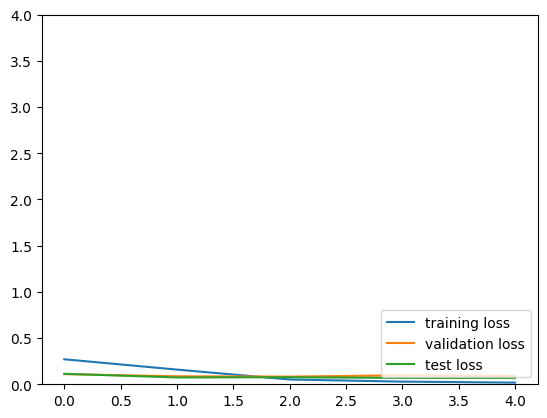

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_loss, label='training loss')
plt.plot(validation_loss, label='validation loss')
plt.plot(test_loss, label='test loss')
plt.legend(loc='lower right')
plt.ylim(0,4)
plt.show()

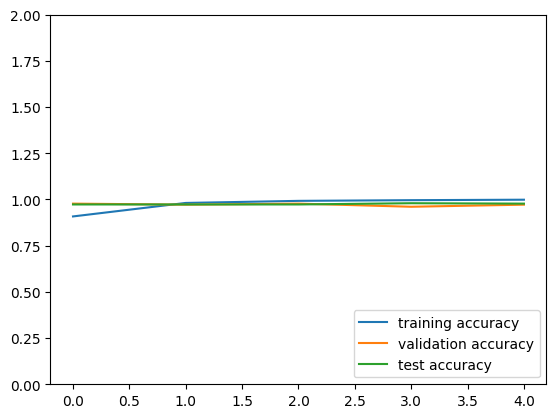

In [ ]:
plt.plot(train_acc, label='training accuracy')
plt.plot(validation_acc, label='validation accuracy')
plt.plot(test_acc, label='test accuracy')
plt.legend(loc='lower right')
plt.ylim(0,2)
plt.show()